## Auto Correlation Plots for Publication

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
sys.path.append("../scripts/") 
from lab import *
import os
params = {'figure.figsize': (6, 4),
         'xtick.labelsize':12,
         'ytick.labelsize':12,
         'lines.linewidth': 2}
plt.rcParams.update(params)

#### choose settings

In [2]:
# choose settings
##### settings ########
LSST      = False
#if not LSST redhsift kernel
z0_1      = 1.0
sigma_z_1 = 0.4
z0_2      = 1.0
sigma_z_2 = 0.4
bin_num1 = 'all'
bin_num2 = 'all'
# choose zmax as high as needed and as low as possible
zmax  = 3
bias  = 'simple'
chimax = chi_z(zmax)
print('zmax=%d'%zmax, 'chimax=%d'%chimax)
#########################
legend = False
stylelabel= 'seaborn-colorblind'

zmax=3 chimax=4408


In [3]:
if LSST:
    file_ext = 'lsst_%s_%s'%(str(bin_num1), str(bin_num2))
else:
    file_ext = 'gaussgal_z0%d_%d_sigmaz%d_%d'%(z0_1*10,z0_2*10,sigma_z_1*10,sigma_z_2*10)
    
file_ext+=bias+'_bias'

file_ext+=  'zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print(file_ext, file_ext2)


params = {}
params['LSST']    = LSST
params['z01']     = z0_1
params['sigma_z1']= sigma_z_1
params['z02']     = z0_2
params['sigma_z2']= sigma_z_2
params['bin_num1']= bin_num1
params['bin_num2']= bin_num2
params['chimax']  = chimax
params['bias']    = bias
params['ext']     = file_ext
params['ext2']    = file_ext2

if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')

print(params['bin_num2'])
try:
    pickle.load(open('../settings/params_auto_%s.pkl'%file_ext,'rb'))
except:
    raise ValueError('settings file does not exist')

gaussgal_z010_10_sigmaz4_4simple_biaszmax30 zmax30
all


In [4]:
plotpath = '../plots/clgg_%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

In [5]:
if LSST:
    kernel1 = gal_clus(dNdz_LSST, b=bias_func, bin_num=bin_num1)
    kernel2 = gal_clus(dNdz_LSST, b=bias_func, bin_num=bin_num2)
else:
    kernel1 = gal_clus(Gauss_redshift(sigma_z=sigma_z_1,z0=z0_1), bias_func)
    kernel2 = gal_clus(Gauss_redshift(sigma_z=sigma_z_2,z0=z0_2), bias_func)
    

#### plot redhift kernels

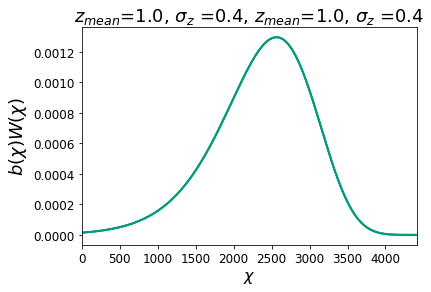

In [6]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('LSST bin=%s, bin=%s'%(str(bin_num1),str(bin_num2)),fontsize=18)
    else:
        ax1.set_title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0_1, sigma_z_1, z0_2, sigma_z_2),fontsize=18)   
    chis = np.linspace(1,chimax,20000)
    ax1.plot(chis, kernel1(chis),label='bin 1')
    ax1.plot(chis, kernel2(chis), label='bin 2')
    ax1.set_xlabel('$\chi$',fontsize=16)
    ax1.set_ylabel('$b(\chi)W(\chi)$',fontsize=18)
    if legend:
        ax1.legend(loc='best',fontsize=16)
    ax1.set_xlim(0,chimax)
    fig.savefig(plotpath+'redshiftkernels_%s.png'%file_ext, bbox_inches='tight',dpi=400)

In [7]:
L = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)/2.),100)

#### leading order cross correlation and magnification bias

In [8]:
ell_,Cl_gg   = np.load('../output/cls/Clgg_%s.npy'%(file_ext))
_,mag1 = np.load('../M_matrices/MgJbias_%s.npy'%(file_ext))
_,mag2 = np.load('../M_matrices/MJJbias_%s.npy'%(file_ext))

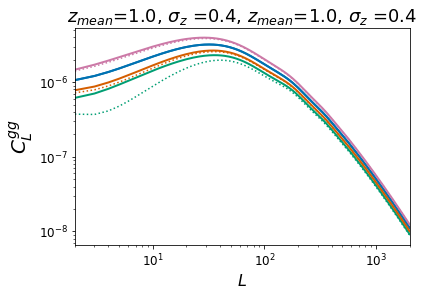

In [9]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('LSST bin=%s, bin=%s'%(str(bin_num1),str(bin_num2)),fontsize=18)
    else:
        ax1.set_title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0_1, sigma_z_1, z0_2, sigma_z_2),fontsize=18)  
    p= ax1.loglog(ell_,Cl_gg,label='uncorrected (s=0.4)')
    ax1.loglog(ell_,Cl_gg,c=p[0].get_color())
    for s in [0.8,0.6,0.2]:
        mag1_= mag1*5.*(s-0.4)
        mag2_= mag2*(5.*(s-0.4))**2
        p = ax1.loglog(ell_,mag1_+Cl_gg,ls=':', lw=1.5)
        ax1.loglog(ell_,-(mag1_+Cl_gg),ls=':', c=p[0].get_color(),lw=1.5)
        ax1.semilogx(ell_,mag1_+mag2_+Cl_gg,ls='-', c=p[0].get_color(), label='s=%.1f'%s)
        ax1.semilogx(ell_,-(mag1_+mag2_+Cl_gg),ls='--', c=p[0].get_color())
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_ylabel(r'$C_L^{g g}$', fontsize=20)

    ax1.set_xlim(min(ell_),max(ell_))
    if legend:
        legend2 = ax1.legend(fontsize=16, loc=(0.01,0.03))
        lines = ax1.get_lines()
        legend1 = plt.legend([lines[i] for i in [3,4]], ['$C_L^{gg}+C_L^{Jg}$','$C_L^{gg}+C_L^{Jg}+C_L^{JJ}$'], fontsize=16, framealpha=0.9, loc=(0.49,0.03))
        ax1.add_artist(legend1)
        ax1.add_artist(legend2)
    fig.savefig(plotpath+'clgg_magbias_%s.png'%file_ext, bbox_inches='tight',dpi=400)


In [10]:
L, LimberTerms,LimberTerm13,LimberTerm22=np.load('../output/results/auto_LimberTerms_%s.npy'%file_ext)
L, NoLimberTerms,NoLimberTerm1,NoLimberTerm2=np.load('../output/results/auto_NoLimberTerms_%s.npy'%file_ext)

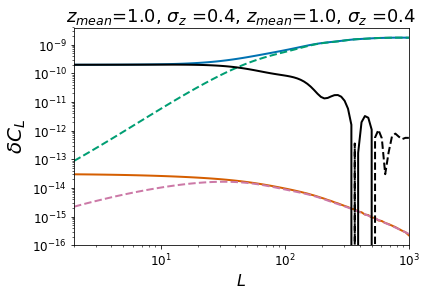

In [11]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('LSST bin=%s, bin=%s'%(str(bin_num1),str(bin_num2)),fontsize=18)
    else:
        ax1.set_title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0_1, sigma_z_1, z0_2, sigma_z_2),fontsize=18)   
    #plt.title('Post Born terms (without Jacobian)',fontsize=14)
    ax1.loglog(L,LimberTerm22,ls='-',label='$[22A]$',lw=2)
    p=ax1.loglog(L,2*LimberTerm13,ls='--',label='$-[31a]$',lw=2)
    ax1.loglog(L,-2*LimberTerm13,ls='-',lw=2, c=p[0].get_color())
    ax1.loglog(L,NoLimberTerm1,label='$[22B]$',lw=2)
    ax1.loglog(L,-NoLimberTerm2,ls='--',label='$-[13b+31b]$',lw=2)
    ax1.loglog(L,LimberTerms+NoLimberTerms,ls='-',color='black',label='sum',lw=2)
    ax1.loglog(L,-(LimberTerms+NoLimberTerms),ls='--',color='black',lw=2)
    if legend:
        ax1.legend(fontsize=16, loc='best',ncol=1)
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_ylabel('$\delta C_L$',fontsize=20)
    ax1.set_xlim(min(L),max(L))
    fig.savefig(plotpath+'postbornterms_%s.png'%file_ext, bbox_inches='tight',dpi=400)

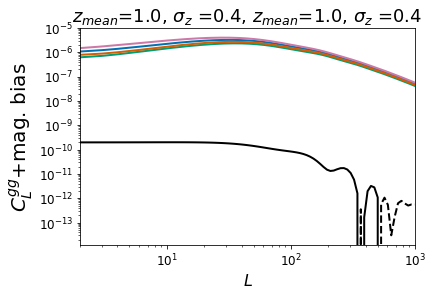

In [12]:
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('LSST bin=%s, bin=%s'%(str(bin_num1),str(bin_num2)),fontsize=18)
    else:
        ax1.set_title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0_1, sigma_z_1, z0_2, sigma_z_2),fontsize=18)   
    #plt.title('Post Born terms (without Jacobian)',fontsize=14
    ax1.loglog(L,LimberTerms+NoLimberTerms,ls='-',c='k',lw=2,label='corrections')
    ax1.loglog(L,-(LimberTerms+NoLimberTerms),ls='--',c='k',lw=2)
    p=ax1.semilogx(ell_,Cl_gg,ls='-', label='s=0.4')
    ax1.semilogx(ell_,-Cl_gg,ls='--', c=p[0].get_color())
    for s in [0.8,0.6,0.2]:
        mag1_=mag1*5*(s-0.4)
        mag2_=mag2*(5*(s-0.4))**2
        p=ax1.semilogx(ell_,Cl_gg+mag1_+mag2_,ls='-', label='s=%.1f'%s)
        ax1.semilogx(ell_,-(Cl_gg+mag1_+mag2_),ls='--', c=p[0].get_color())
    if legend:
        ax1.legend(loc='best',fontsize=16, ncol=1, framealpha=0.9)
    ax1.set_ylabel('$C_L^{g g}$+mag. bias',fontsize=20)
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_xlim(min(L),max(L))
    fig.savefig(plotpath+'postbornterms_vs_signal_%s.png'%file_ext, bbox_inches='tight',dpi=400)

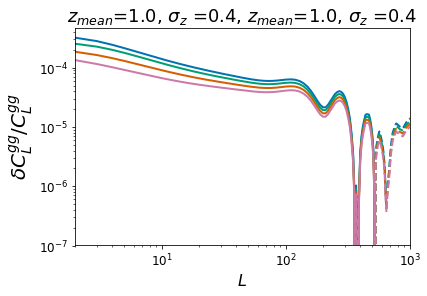

In [13]:
allterms = np.interp(ell_,L,(LimberTerms+NoLimberTerms))
with plt.style.context(stylelabel):
    fig, ax1 = plt.subplots()
    if LSST:
        ax1.set_title('LSST bin=%s, bin=%s'%(str(bin_num1),str(bin_num2)),fontsize=18)
    else:
        ax1.set_title('$z_{mean}$=%.1f, $\sigma_z$ =%.1f, $z_{mean}$=%.1f, $\sigma_z$ =%.1f'%(z0_1, sigma_z_1, z0_2, sigma_z_2),fontsize=18)   
    for s in [0.8,0.6,0.4,0.2]:
        mag1_=mag1*5*(s-0.4)
        mag2_=mag2*(5*(s-0.4))**2
        corr_signal=Cl_gg+mag1_+mag2_
        p= ax1.loglog(ell_,allterms/corr_signal,lw=2,label='s=%.1f'%s)
        ax1.loglog(ell_,-allterms/corr_signal,lw=2,ls='--',color=p[0].get_color())


    if legend:
        ax1.legend(fontsize=16)
    ax1.set_xlim(min(L), max(L))
    ax1.set_xlabel('$L$',fontsize=16)
    ax1.set_ylabel('$\delta C_L^{g g}/C_L^{g g}$',fontsize=20)
    fig.savefig(plotpath+'signal_vs_corrections_%s_relative.png'%file_ext, bbox_inches='tight',dpi=400)